# EWAS QC of summary stats: CHS
**author**: Jesse Marks (jmarks@rti.org)<br>
**GitHub Issue**: [183](https://github.com/RTIInternational/bioinformatics/issues/185#issuecomment-1265659903)<br>
**Overarching goal**:
1. Model performance as determined by:
    a. Lambdas across analyses<br>
    b. Generating a list of top CpGs, which we will ask the cohorts to plot underlying data for QC purposes (real result or driven by outliers)<br>
    c. Comparing results across cohorts (e.g., replication would be positive, major differences would be a concern – this is hard to test)<br>
    d. Orders of magnitude to confirm betas were provided with the correct unit<br>
2. Model decisions still needed:
    a. Decide if and how outlier DNAm values should be handled (ARIC removed and CHS has included them)
    b. Should BACON adjustment be applied. If so, we will need to add that to our QC pipeline
3. After QC/model decisions are made, finalize analysis plan and get updated/finalized EWAS from all cohorts
4. Meta-analyze according to current plan (below)

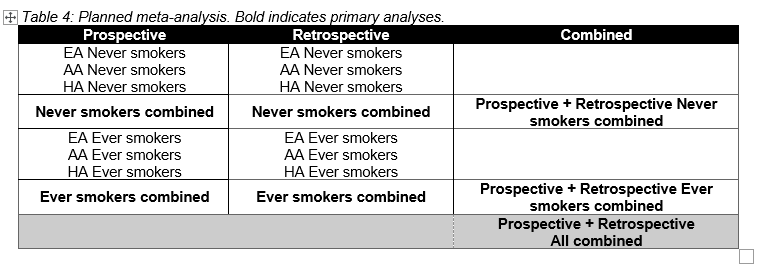

--- 
Analyses from each cohort include:
1. Prospective/Delta model   &  LMM model (all data points)
2. EA & AA & sometimes HA
3. Ever smokers & Never smokers
4. FEV1, FVC, FEV1/FVC (ratio)


## CHS QC function

In [55]:
#install.packages('QCEWAS')

#if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("IlluminaHumanMethylationEPICmanifest")
#BiocManager::install("IlluminaHumanMethylation450kanno.ilmn12.hg19")

#Load libraries
library(QCEWAS)
library(IlluminaHumanMethylationEPICmanifest)
library(IlluminaHumanMethylation450kanno.ilmn12.hg19)
library(devtools)
library(stringr)


chs_qc <- function(thresh=1E-8, results_folder, out_dir, keep_cols) {
    #################################################################################################### 
    #INPUT
    # thresh: the CpG threshold to apply to methylation results when creating a top-hits file
    # results_folder: The path to the folder that contains the methylation results we will QC
    # out_dir: The path to the folder where we will store the output QC results
    # keep_cols: list of column names (strings) from the input results we are interested in. Must
    #            be in the order: 1. probeID, 2. chromosome, 3. mapinfo (position), 4. beta, 5. se, 6. pval
    # 
    #OUTPUT
    # 5 QC plots (png), 3 text files 
    
    dir.create(file.path(out_dir))
    ann450<-as.data.frame(getAnnotation(IlluminaHumanMethylation450kanno.ilmn12.hg19)) # Load Manifest File (CpG annotations)
    

    # Load Data: create a list of the files from your target directory
    file_list <- list.files(path=results_folder, pattern="*csv") # get results file names (input)
    file_location <- paste0(results_folder, file_list) # prepend the directory path

    # initialize dataframe to hold most significant CpGs
    top_hits <- setNames(data.frame(matrix(ncol = 7, nrow = 0)), c("PROBEID", "CHR", "MAPINFO","BETA", "SE", "P_VAL", "Source"))

    # run QC on each set of results
    for (i in 1:length(file_list)){
        my_data <- read.csv(file_location[i])
        my_data <- my_data[, keep_cols] # just necessary columns

        #Rename columns to expected columns names for the QC package Columns: PROBEID, BETA, SE, P_VAL
        colnames(my_data)[colnames(my_data) == keep_cols[1]] <- "PROBEID"
        colnames(my_data)[colnames(my_data) == keep_cols[2]] <- "CHR"
        colnames(my_data)[colnames(my_data) == keep_cols[3]] <- "MAPINFO"
        colnames(my_data)[colnames(my_data) == keep_cols[4]] <- "BETA"
        colnames(my_data)[colnames(my_data) == keep_cols[5]] <- "SE"
        colnames(my_data)[colnames(my_data) == keep_cols[6]] <- "P_VAL"

        # QC
        model_name <- str_sub(file_list[i], start=1, end=-5) # remove .csv
        dir.create(file.path(out_dir, model_name))
        outname <- paste0(out_dir, model_name, "/QC_Results_", model_name) # add directory for each set of results
        print(outname)
        QC_results <- EWAS_QC(data = my_data,
                              outputname = outname,
                              save_final_dataset = TRUE)

        # Manhattan plot    
        EWAS_plots(data = my_data,
                   plot_QQ = FALSE, 
                   plot_Man = TRUE,
                   save_name = outname)

        # CpGs with Pvalues < threshold (Output file)

        # Print Top Hits, add the source column
        # If there are no top hits it will throw an error. This for-loop resolves that issue.
        top <- my_data[ which(my_data$P_VAL< pval_threshold),]
        if (length(top$P_VAL) > 0) { 
            top$Source <- output
        } else {
            top$Source <- character()
        }

        top_hits <- rbind(top_hits, top)
        tname  <- paste0(out_dir, model_name, "/top_hits_", model_name, ".txt") # name of top-hits file (pval < thresh)
        write.table(top_hits, tname, quote=FALSE, row.names = FALSE)
    } # end forloop
} # end function

## Delta model

In [31]:
results_folder <- "/Users/jmarks/Research Triangle Institute/EWAS of Pulmonary Function Decline - CHS/DELTA/" # folder where results are
out_dir <- "/Users/jmarks/projects/pulmonary/EWAS_of_Pulmonary_Function_Decline/CHS/DELTA/" # where to store processed results
keep_cols <- c("Name", "CHR", "MAPINFO", "beta", "SE", "P") # columns of interest (order matters)

chs_qc(results_folder=results_folder, out_dir=out_dir, keep_cols=keep_cols)

## LMM model 

In [ ]:
results_folder <- "/Users/jmarks/Research Triangle Institute/EWAS of Pulmonary Function Decline - CHS/LMM/" # folder where results are
out_dir <- "/Users/jmarks/projects/pulmonary/EWAS_of_Pulmonary_Function_Decline/CHS/LMM/" # where to store processed results
keep_cols <- c("Name", "CHR", "MAPINFO", "beta.interaction", "SE.interaction", "P.interaction") # columns of interest (order matters)

chs_qc(results_folder=results_folder, out_dir=out_dir, keep_cols=keep_cols)

### RestrictedTo3Obs

In [ ]:
results_folder <- "/Users/jmarks/Research Triangle Institute/EWAS of Pulmonary Function Decline - CHS/LMM/RestrictedTo3Obs/" # folder where results are
out_dir <- "/Users/jmarks/projects/pulmonary/EWAS_of_Pulmonary_Function_Decline/CHS/LMM/RestrictedTo3Obs/" # where to store processed results
keep_cols <- c("Name", "CHR", "MAPINFO", "beta.interaction", "SE.interaction", "P.interaction") # columns of interest (order matters)

chs_qc(results_folder=results_folder, out_dir=out_dir, keep_cols=keep_cols)

In [1]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur/Monterey 10.16

Matrix products: default
BLAS/LAPACK: /Users/jmarks/miniconda3/lib/libopenblasp-r0.3.20.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.3     utf8_1.2.2      digest_0.6.29   crayon_1.5.1   
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.1 jsonlite_1.8.0 
 [9] evaluate_0.15   pillar_1.7.0    rlang_1.0.3     cli_3.3.0      
[13] uuid_1.1-0      vctrs_0.4.1     ellipsis_0.3.2  IRkernel_1.3   
[17] tools_4.1.3     glue_1.6.2      fastmap_1.1.0   compiler_4.1.3 
[21] base64enc_0.1-3 pbdZMQ_0.3-7    htmltools_0.5.2

In [1]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.3     utf8_1.2.2      digest_0.6.29   crayon_1.5.1   
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.1 jsonlite_1.8.0 
 [9] evaluate_0.15   pillar_1.7.0    rlang_1.0.3     cli_3.3.0      
[13] uuid_1.1-0      vctrs_0.4.1     ellipsis_0.3.2  IRkernel_1.3   
[17] tools_4.2.1     glue_1.6.2      fastmap_1.1.0   compiler_4.2.1 
[21] base64enc_0.1-3 pbdZMQ_0.3-7    htmltools_0.5.2